In [18]:
import os
import time
from datetime import datetime

import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import random 

# Tensorflow

In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

True

# Case

In [20]:
folders = ['Rough','UTS','Elon2']
index = 0
CASE = folders[index]

In [21]:
from prepross import LoadAndProcess
xtrain,xval,xtest,ytrain,yval,ytest = LoadAndProcess(index)
x = pd.concat((xtrain,xtest,xval),axis=0)
y = pd.concat((ytrain,ytest,yval),axis=0)

# Networks

In [22]:
# Hyperparameters
lossfn = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsolutePercentageError(),tf.keras.losses.MeanAbsoluteError()]
lossfn = lossfn[index]
optimizer = [tf.keras.optimizers.Adam(learning_rate=i,beta_1=0.09,beta_2=0.9) for i in [5e-2,1e-2,5e-3]]
optimizer = optimizer[index]
metrics = ['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]

In [23]:
# Models
files = [f for f in os.listdir(CASE) if f.startswith(CASE) and not f.endswith('k.h5')]

In [24]:
model =  tf.keras.models.load_model(os.path.join(CASE+"/"+files[0]),compile=False)

In [25]:
# Run
models = {}
val_performance = {}
performance = {}
ove_performance = {}
for i in files:
    print(i)
    models[str(i)] = tf.keras.models.load_model(os.path.join(CASE+"/"+i),compile=False)
    models[str(i)].compile(
        optimizer = tf.optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam'),
        loss = lossfn,
        metrics = metrics
    )
    val_performance[str(i)] = models[str(i)].evaluate(xval,yval,verbose=0)
    performance[str(i)] = models[str(i)].evaluate(xtest,ytest, verbose=0)
    ove_performance[str(i)] = models[str(i)].evaluate(x,y, verbose=0)

Roughmodel.h5


# Performence

In [26]:
def value_getter(item):
    return item[1][2]
sortP = sorted(performance.items(),key=value_getter)
sortV = sorted(val_performance.items(),key=value_getter)
sortO =sorted(ove_performance.items(),key=value_getter)
print('Performence on test',sortP[0])
print('Performence on val',sortV[0])
print('Performence on df',sortO[0])

Performence on test ('Roughmodel.h5', [886.7666625976562, 886.7666625976562, 26.28535270690918, 27.507036209106445])
Performence on val ('Roughmodel.h5', [528.9088745117188, 528.9088745117188, 18.244064331054688, 17.402734756469727])
Performence on df ('Roughmodel.h5', [552.1532592773438, 552.1532592773438, 19.39580726623535, 19.122678756713867])


# Visualize Best

In [39]:
Pmodel = tf.keras.models.load_model(os.path.join(CASE+"/"+sortP[0][0]),compile=False)
Pmodel.compile(optimizer = optimizer,loss = lossfn,metrics=metrics)
Vmodel = tf.keras.models.load_model(os.path.join(CASE+"/"+sortV[0][0]),compile=False)
Vmodel.compile(optimizer = optimizer,loss = lossfn,metrics=metrics)
Omodel = tf.keras.models.load_model(os.path.join(CASE+"/"+sortO[0][0]),compile=False)
Omodel.compile(optimizer = optimizer,loss = lossfn,metrics=metrics)

In [28]:
for i in sortO[:10]:
    print(i[0])

Roughmodel.h5


In [29]:
for i in sortP[:10]:
    print(i[0])

Roughmodel.h5


/tmp/ipykernel_2101041/4052370062.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


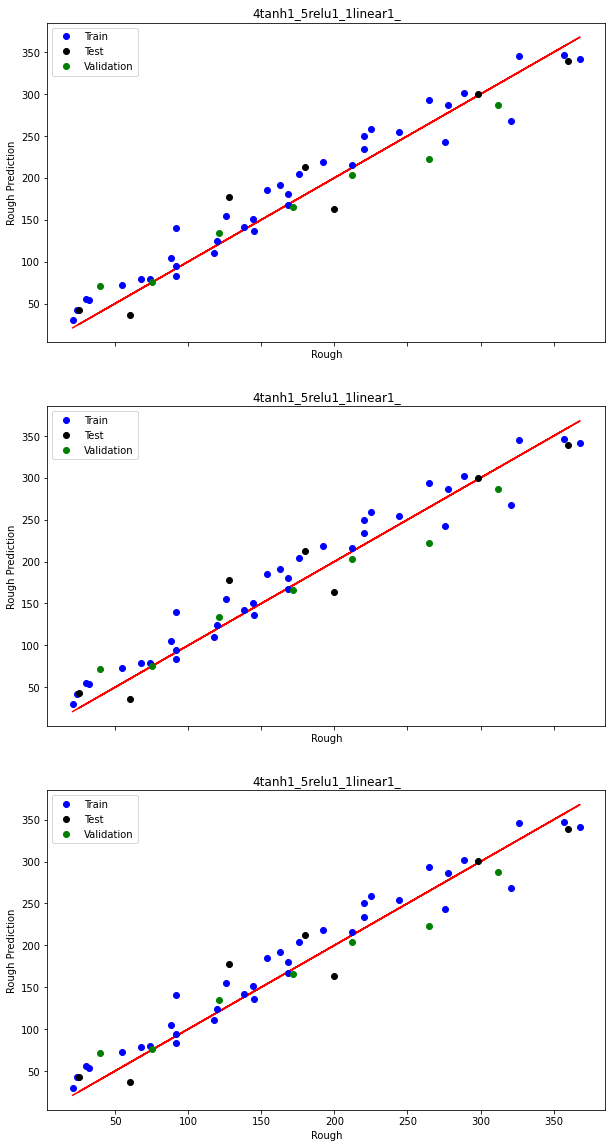

In [30]:
rows, cols = 3,1
fig, gs = plt.subplots(rows, cols,figsize =(10,20),sharex='col',sharey='row')

for i,mod in enumerate([Pmodel,Vmodel,Omodel]):    
    ypred_tr =  mod.predict(xtrain,verbose=0).squeeze()
    ypred_te = mod.predict(xtest,verbose=0).squeeze()
    ypred_va = mod.predict(xval,verbose=0).squeeze()
    ax = fig.add_subplot(gs[i])
    ax.plot(y,y,'r')
    ax.plot(ytrain,ypred_tr,'bo',label="Train")
    ax.plot(ytest,ypred_te,'ko',label = 'Test')
    ax.plot(yval,ypred_va,'go',label='Validation')
    ax.legend()
    plt.title(mod.name)
    plt.xlabel(CASE)
    plt.ylabel(CASE +' Prediction')
fig.show()

1/1 [==============================] - 0s 27ms/step


Text(0, 0.5, 'Rough Prediction')

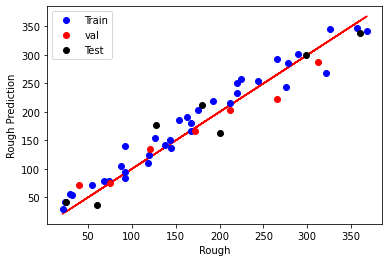

In [40]:
ypredtr =  Omodel.predict(xtrain).squeeze()
ypredts = Omodel.predict(xtest).squeeze()
ypredvl = Omodel.predict(xval).squeeze()

y = [*ytrain,*ytest,*yval]
plt.plot(y,y,'r')
plt.plot(ytrain,ypredtr,'bo',label="Train")
plt.plot(yval,ypredvl,'ro',label="val")
plt.plot(ytest,ypredts,'ko',label = 'Test')
plt.legend()
plt.xlabel(CASE)
plt.ylabel(CASE +' Prediction')

In [41]:
print('Performance on Validation Dataset:')
Omodel.evaluate(xval,yval)
print('Performance on Test dataset:')
Omodel.evaluate(xtest,ytest)
print('Performance on Train Dataset:')
Omodel.evaluate(xtrain,ytrain)
print('Performance on Dataset:')
Omodel.evaluate(xtrain,ytrain)

Performance on Validation Dataset:
1/1 [==============================] - 0s 301ms/step - loss: 528.9089 - mean_squared_error: 528.9089 - mean_absolute_error: 18.2441 - mean_absolute_percentage_error: 17.4027
Performance on Test dataset:
1/1 [==============================] - 0s 26ms/step - loss: 886.7667 - mean_squared_error: 886.7667 - mean_absolute_error: 26.2854 - mean_absolute_percentage_error: 27.5070
Performance on Train Dataset:
2/2 [==============================] - 0s 3ms/step - loss: 491.6094 - mean_squared_error: 491.6094 - mean_absolute_error: 18.2801 - mean_absolute_percentage_error: 13.5466
Performance on Dataset:
2/2 [==============================] - 0s 3ms/step - loss: 491.6094 - mean_squared_error: 491.6094 - mean_absolute_error: 18.2801 - mean_absolute_percentage_error: 13.5466


[491.609375, 491.609375, 18.280126571655273, 13.546560287475586]

# Gene

In [31]:
len(CASE)

5

In [32]:
import re
layerC = { 'tanh' : [0,0,0],
        'linear' : [0,0,0],
        'sigmoid' : [0,0,0],
        'relu' : [0,0,0]}
layerS = { 'tanh' : [0,0,0],
        'linear' : [0,0,0],
        'sigmoid' : [0,0,0],
        'relu' : [0,0,0]}
def getLayers(i):
    i = i.split('_')
    i[0] = ''.join(re.split("[^a-zA-Z]*", i[0][len(CASE):]))
    i[1] = ''.join(re.split("[^a-zA-Z]*", i[1]))
    i[2] = ''.join(re.split("[^a-zA-Z]*", i[2]))
    i[3] =''.join( re.split("[^a-zA-Z]*", i[3]))
    i = i[:-2]
    return i
    

In [33]:
searchBestNum = 40

In [34]:
for i in sortO[:searchBestNum]:
    layers = getLayers(i[0])
    for i,l in enumerate(layers):
        layerC[l][i] +=1
        layerS[l][i] += performance[i[0]][0]
        
for l in layerS.keys():
    for i,c in enumerate(layerS[l]):
        layerS[l][i] = c / (layerC[l][i]+ 1e-10) 
layerS

IndexError: list index out of range

In [ ]:
oschemaScore = {}
pschemaScore = {}
schemasCount = {}
from architectures import getSchemas
schemas = getSchemas(['tanh','sigmoid','relu','linear'])

for i in sortO[:searchBestNum]:
    layers = getLayers(i[0])
    lname = ''
    for j in layers:
        lname+=j
    pschemaScore[lname] = 0
    oschemaScore[lname] = 0
    schemasCount[lname] = 0
for i in sortO[:40]:
    layers = getLayers(i[0])
    lname = ''
    for j in layers:
        lname+=j
    pschemaScore[lname] += performance[i[0]][0]
    oschemaScore[lname] += ove_performance[i[0]][0]
    schemasCount[lname] += 1

for name in oschemaScore.keys():
    oschemaScore[name] = oschemaScore[name]/schemasCount[name]
    pschemaScore[name] = pschemaScore[name]/schemasCount[name]

def value_getter(item):
    return item[1]
bSchemaO = sorted(oschemaScore.items(),key=value_getter)
bSchemaP = sorted(pschemaScore.items(),key=value_getter)
bSchemaP[:10]

In [ ]:
bSchemaO[:10]